# Importat librerias necesarias

In [45]:
import xarray as xr

In [46]:
ds = xr.open_dataset('../../data/era5_2021.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 89, time: 12)
Coordinates:
  * longitude  (longitude) float32 -85.0 -84.75 -84.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 2.0 1.75 1.5 1.25 ... -19.5 -19.75 -20.0
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-25 13:36:41 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

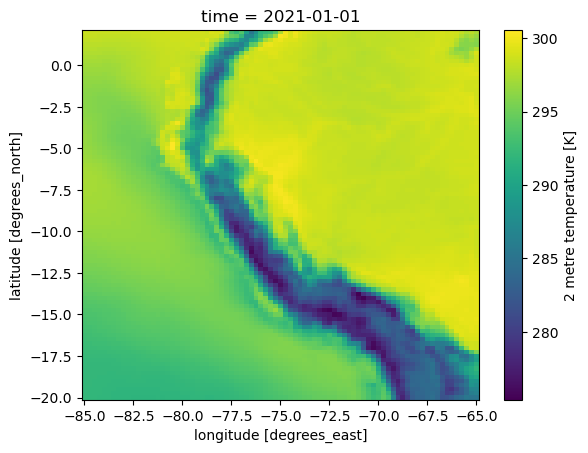

In [47]:
ds['t2m'][0].plot()

In [48]:
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth
from cartopy.feature import ShapelyFeature, OCEAN, LAKES
from cartopy.crs import PlateCarree

In [49]:
# Download the Natural Earth shapefile for country boundaries at 10m resolution
shapefile = natural_earth(category='cultural',
                          resolution='10m',
                          name='admin_0_countries')


In [50]:
# Sort the geometries in the shapefile into Chinese/Taiwanese or other
country_geos = []
other_land_geos = []
for record in ShapeReader(shapefile).records():
    if record.attributes['ADMIN'] in ['Peru']:
        country_geos.append(record.geometry)
    else:
        other_land_geos.append(record.geometry)

In [51]:
projection = PlateCarree()

In [52]:
countries = ShapelyFeature(country_geos,
                           crs=projection,
                           facecolor='none',
                           edgecolor='black',
                           lw=1.5)

In [53]:
import numpy as np

In [54]:
T = ds['t2m'][0]
U = ds['u10'][0]
V = ds['v10'][0]

lat = ds['latitude']
lon = ds['longitude']
lon, lat = np.meshgrid(lon, lat)


In [55]:
from matplotlib import pyplot as plt

In [56]:
print(T.values.min())
print(T.values.max())

275.38608
300.55988


In [57]:
import cmaps
import geocat.viz as gv

In [58]:
# Define the contour levels
clevs = np.linspace(275, 300, 12, dtype=float).round()

# Importando la base del colormap para trabajar
newcmp = gv.truncate_colormap(cmaps.BkBlAqGrYeOrReViWh200,
                              minval=0.1,
                              maxval=0.6,
                              n=len(clevs))


/home/christian/miniconda3/envs/geocat/lib/python3.9/site-packages/geocat/viz/util.py:550: UserWarning: Trying to register the cmap 'trunc(BkBlAqGrYeOrReViWh200,0.10,0.60)' which already exists.
  cm.register_cmap(name, new_cmap)


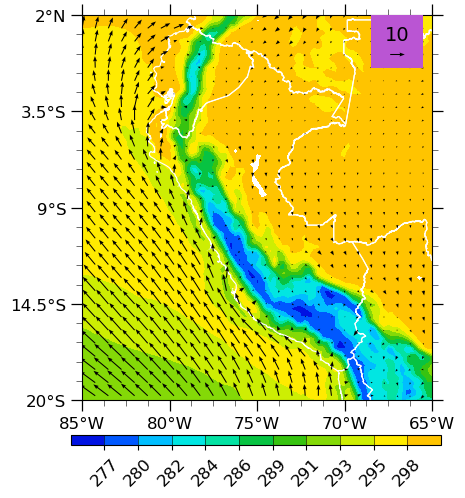

In [76]:
# Generate figure (set its size (width, height) in inches) and axes using Cartopy
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=projection)
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=projection)

fname = '../../data/shapefiles/vc965bq8111.shp'
ax.add_geometries(ShapeReader(fname).geometries(), facecolor='none', edgecolor='white', lw=0.8, crs=projection)


cf = ax.contourf(lon,lat, T.values, levels=clevs, cmap=newcmp, zorder=1)

#  vertical y horizontal  
cax = plt.axes((0.14, 0.02, 0.74, 0.02))
cbar = plt.colorbar(cf,
                    ax=ax,
                    cax=cax,
                    ticks=(clevs[1:-1]),
                    drawedges=True,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12, rotation=45)


Q = ax.quiver(lon[::3,::3],
              lat[::3,::3],
              U[::3,::3],
              V[::3,::3],
              color='black',
              width=.003,
              scale=120.,
              headwidth=3.75,
              zorder=4)


# Dibujo del cuadro del vector de velocidad de referencia
rect = plt.Rectangle((-68.5, -1),
                     3,
                     3,
                     facecolor='mediumorchid',
                     edgecolor=None,
                     zorder=4)
ax.add_patch(rect)

ax.quiverkey(Q,
             0.9,
             0.9,
             5,
             '10',
             labelpos='N',
             color='black',
             coordinates='axes',
             fontproperties={'size': 14},
             labelsep=0.1)

# definimos las caracteristicas de los "ticks"
gv.set_axes_limits_and_ticks(ax,
                             xticks=np.linspace(lon.min(), lon.max(), 5),
                             yticks=np.linspace(lat.min(), lat.max(), 5))

# Adicion de las latitudes y longitudes correspondientes
gv.add_lat_lon_ticklabels(ax)

# configuración de los "ticks" mayores y menores
gv.add_major_minor_ticks(ax,
                         x_minor_per_major=4,
                         y_minor_per_major=5,
                         labelsize=12)

fig.savefig('fig/Temp_202101.png', dpi = 200, facecolor='w', bbox_inches = 'tight', 
            pad_inches = 0.1)